In [1]:
from fastai.vision.all import *
from torch.utils.data.dataset import Dataset
import torch
import torchaudio
from torchaudio.transforms import *
from pathlib import Path
import numpy as np
import glob
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn.metrics import classification_report

In [2]:
class ResBlock(nn.Module):
    def __init__(self, dilation=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(16, 16, 3, dilation=dilation, padding=dilation)
        self.batch1 = nn.BatchNorm2d(16)
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 16, 3, dilation=dilation, padding=dilation)
        self.batch2 = nn.BatchNorm2d(16)
        self.act2 = nn.ReLU()
        
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        inp = self.dropout(x)
        dil1 = self.conv1(x)
        batch1 = self.batch1(dil1)
        act1 = self.act1(batch1)
        
        dil2 = self.conv2(act1)
        batch2 = self.batch2(dil2)
        act2 = self.act2(batch2)
        
        return inp + act2

In [3]:
class Net(nn.Module):
    def __init__(self, n_out=0):
        super().__init__()
        
        self.n_out = n_out
        
        self.conv1 = nn.Conv2d(3, 16, 3, dilation=1)
        self.act1 = nn.ReLU()
        
        self.res1 = ResBlock(dilation=1)
        self.pool1 = nn.MaxPool2d(1, 2)

        self.res2 = ResBlock(dilation=1) 
        self.pool2 = nn.MaxPool2d(1, 2)

        self.res3 = ResBlock(dilation=1)
        
        self.fc = nn.Linear(96, self.n_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.res1(x)
        x = self.pool1(x)
        x = self.res2(x)
        x = self.pool2(x)
        x = self.res3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = torch.Tensor(x.cpu().float()).float().cuda()
        
        return x

In [4]:
path = Path('new_new_data')

In [5]:
def get_radar_items(path_to_data): 
    items = list(map(lambda x: x.ls(), path.ls()))
    
    return [item for sublist in items for item in sublist]

In [6]:
def label_func(fname): return parent_label(fname)

In [7]:
def get_x(img_path):
    signal_data = np.load(img_path)
    spec = torchaudio.transforms.Spectrogram(n_fft=64, win_length=12)
        
    img = torch.stack((
        torch.tensor(signal_data[0]),
        torch.tensor(signal_data[1]),
        torch.tensor(signal_data[2]),
    ))
    
    img_hwc = torch.transpose(spec(img), 0, 2).numpy()
    
    return img_hwc.astype(np.uint8)[:, :10]

In [8]:
all_items = np.array([get_x(pth) for pth in get_radar_items(path)])
mi, mx = (all_items.min(), all_items.max())
mx

27

In [9]:
def get_x(img_path):
    signal_data = np.load(img_path)
    spec = torchaudio.transforms.Spectrogram(n_fft=64, win_length=12)
        
    img = torch.stack((
        torch.tensor(signal_data[0]),
        torch.tensor(signal_data[1]),
        torch.tensor(signal_data[2]),
    ))
    
    img_hwc = torch.transpose(spec(img), 0, 2).numpy()
    optimize_mx = math.floor(math.sqrt(mx)) - 1
    
    return (img_hwc / optimize_mx * 255).astype(np.uint8)[:, :10]

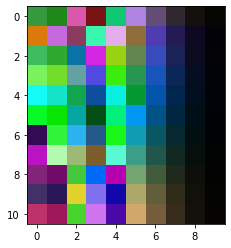

In [12]:
plt.imshow(get_x(path.ls()[0].ls()[0]))

In [13]:
dblock = DataBlock(blocks     = (ImageBlock, CategoryBlock),
                   get_items  = get_radar_items,
                   get_y      = label_func,
                   get_x      = get_x,
                   batch_tfms = Normalize.from_stats(*imagenet_stats)
                  )


In [14]:
batch_size = 64

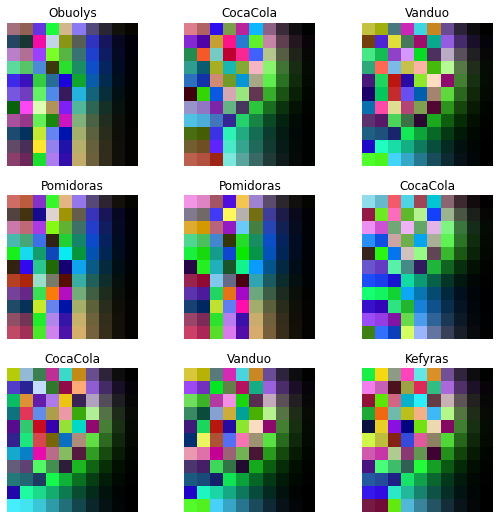

In [15]:
dls = dblock.dataloaders(path, bs=batch_size)
dls.show_batch()

In [16]:
dls.vocab

['Apelsinas', 'CocaCola', 'Kefyras', 'Obuolys', 'Pomidoras', 'Vanduo']

In [17]:
net = Net(n_out=len(dls.vocab))

In [18]:
learn = Learner(dls, xresnet34(), metrics=accuracy)

# learn = Learner(dls, xresnet34(pretrained=False), metrics=accuracy)

# learn = Learner(dls, net, metrics=[accuracy])

SuggestedLRs(valley=0.0010000000474974513)

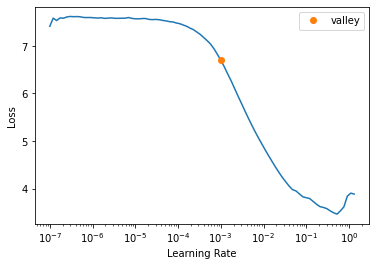

In [19]:
learn.lr_find()

In [20]:
# learn.summary()
# learn.loss_func

In [21]:
lr = 1e-3

In [22]:
learn.fit_one_cycle(33, lr, pct_start=0.7, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,7.434035,7.705050,0.000000,00:01
1,7.221883,6.882029,0.024590,00:01
2,6.974309,6.439185,0.040984,00:01
3,6.682024,5.833245,0.254098,00:01
4,6.315449,4.995469,0.352459,00:01
5,5.837881,3.978557,0.442623,00:01
6,5.292505,2.870631,0.622951,00:01
7,4.674301,1.874002,0.663934,00:01
8,4.066580,1.156953,0.754098,00:01
9,3.479665,0.781936,0.811475,00:01


In [31]:
#learn.unfreeze()

In [32]:
#learn.fit_one_cycle(20, slice(lr/400, lr/4), pct_start=0.7)

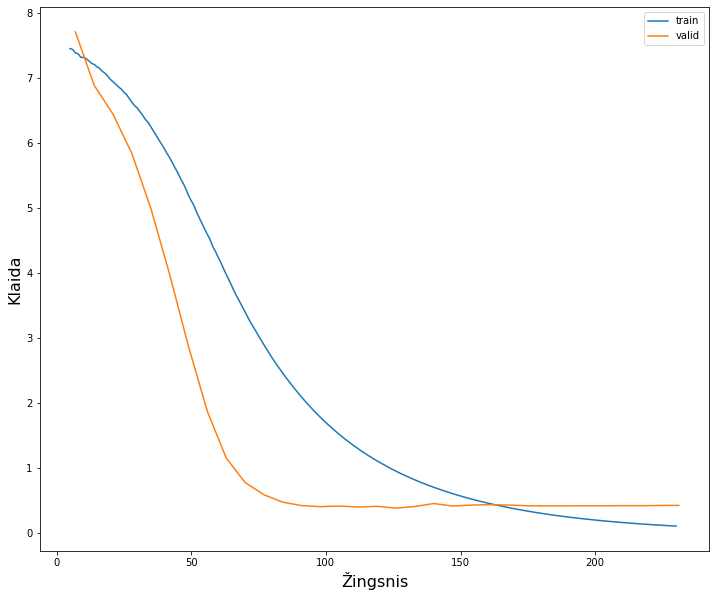

In [23]:
plt.figure(figsize=(12,10))
plt.xlabel('Žingsnis', fontsize=16)
plt.ylabel('Klaida', fontsize=16)
learn.recorder.plot_loss()

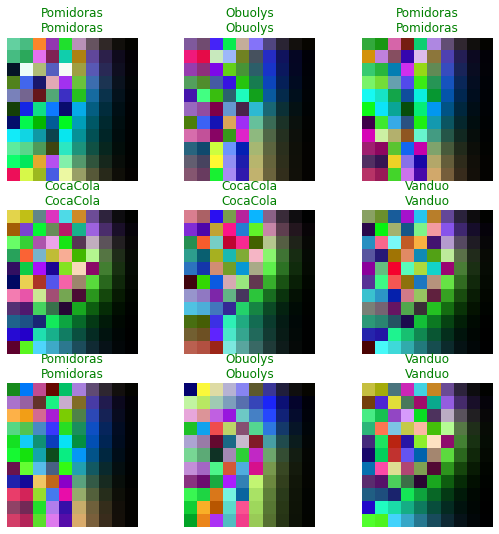

In [24]:
learn.show_results()

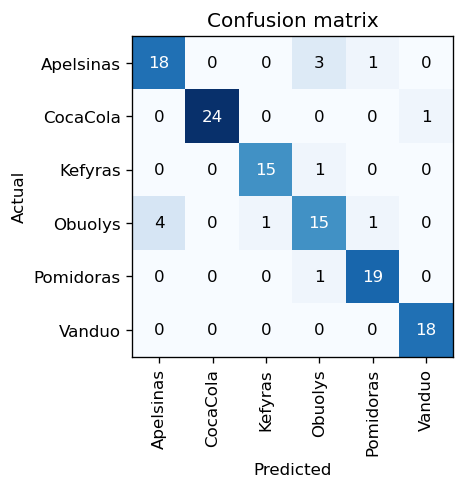

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(dpi=120, title = "Confusion matrix")

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

              precision    recall  f1-score   support

   Apelsinas       0.82      0.82      0.82        22
    CocaCola       1.00      0.96      0.98        25
     Kefyras       0.94      0.94      0.94        16
     Obuolys       0.75      0.71      0.73        21
   Pomidoras       0.90      0.95      0.93        20
      Vanduo       0.95      1.00      0.97        18

    accuracy                           0.89       122
   macro avg       0.89      0.90      0.89       122
weighted avg       0.89      0.89      0.89       122

